> ### EEE4423: Deep Learning Lab

# LAB \#11: Character Generation using LSTM

<h4><div style="text-align: right"> Due date: May 19, 2023. </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab11.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2018142102] [Euijin Hong]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-14 07:41:49.065993


In [2]:
!pip install unidecode --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 9.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import unidecode
import string
import random
import re
import os

import torch
import torch.nn as nn
from torch.autograd import Variable

These sorts of generative models form the basis of machine translation, image captioning, question answering and more.

<img src="http://drive.google.com/uc?export=view&id=16E7HG_dCyfTo9u9qrrhp2eClq6xK6-f_" style="width: 600px;"/>

### 1. Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package

<img src="http://drive.google.com/uc?export=view&id=171lX3vxj60AQNScQi872BHx2Rz6J7-3J" />

In [2]:
file = unidecode.unidecode(open('./dataset-dllab/lab11/lose_yourself_eminem.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 4063


To make inputs out of this big string of data, we will be splitting it into chunks.

In [3]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

r
The souls escaping, through this hole that its gaping
This world is mine for the taking
Make me king, as we move toward a, new world order
A normal life is borin', but super stardom's close to post m


Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [4]:
# Turn string into list of longs
all_characters = string.printable
print(all_characters)

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print('abcDEF is changed to ', char_tensor('abcDEF'))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

abcDEF is changed to  tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [5]:
def random_training_set():    
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:])
    return inputs, targets

### 2. Build the LSTM model [4 points]

#### [Diagram of LSTM]
<img src="http://drive.google.com/uc?export=view&id=1baQ6Ffu-vDcXbOEBYGeLzhmfvaj4DGgW" style="width: 800px;"/>
LSTM consists of cell state, hidden state and 3 gates that modify or use the cell state. The cell state is the key part of the LSTM and you can think that information "flows" in there. The operation of 3 gates are described in below.

#### [Forget Gate]
The forget gate determines which information in the cell state should be erased.
<img src="http://drive.google.com/uc?export=view&id=1sJisl5P0hggmvH4qrcYgSETFKdFdBSH_" style="width: 600px;"/>

#### [Input Gate]
First, the candidate cell state is created using the current input and the previous hidden state. And the input gate determines how much the candidate cell state is reflected to the cell state.
<img src="http://drive.google.com/uc?export=view&id=1Df-k5FORGH7PnXauYcb8qqUpY3Uot9A7" style="width: 600px;"/>

#### [Output Gate]
The output gate determines which elements should be extracted from the cell state to produce the output.
<img src="http://drive.google.com/uc?export=view&id=1JLCGPcrZLOYfjyJhMTvmfixHq5plFj8L" style="width: 600px;"/>

The above expression is summarized as follows,
<img src="http://drive.google.com/uc?export=view&id=1kGq8DwwzizuNcg6GF0GaP1DAu26FFlrB" style="width: 300px;"/>


This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one LSTM layer that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        
        self.encoder = nn.Embedding(input_dim, hidden_dim)
        
        # lstm
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #############
        self.sigmoid = nn.Sigmoid()
        
        # one-depth fully-connected layer in forget gate
        self.forget_layer = nn.Linear(hidden_dim, hidden_dim)
        
        # one-depth fully-connected layer in input gate
        self.input_layer = nn.Linear(hidden_dim, hidden_dim)
        
        # one-depth fully-connected layer in output gate
        self.output_layer = nn.Linear(hidden_dim, hidden_dim)
        
        # one-depth fully-connected layer in candidate cell state
        self.c_state_layer = nn.Linear(hidden_dim, hidden_dim)
        #############
        
        self.decoder = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input, hn, cn):
        #############
        # iterate for number of LSTM layers
        for n in range(n_layers):
            # previous hn and cn are given as an input of a forward function
            hn_1, cn_1 = hn, cn
            
            # for initial LSTM layer, input is the input of the multi-layered LSTM
            if n == 0:
                # convert the input into same shape as hidden input, xn size: [1, 1, 100]
                xn = self.encoder(input)
            # for consequtive LSTM layer, input is the output of the previous LSTM layer
            else:
                # convert the previous ouptut into same shape as hidden input, xn size: [1, 1, 100]
                xn = self.encoder(output.argmax().unsqueeze(0).unsqueeze(0))

            # add encoded input and hidden input to form a gate input (h_(n-1), x_t), size: [1, 1, 100]
            gate_input = torch.add(hn_1, xn)
            
            # calculate f_n
            f_n = self.sigmoid(self.forget_layer(gate_input))
            # calculate i_n
            i_n = self.sigmoid(self.input_layer(gate_input))
            # calculate candidate cell state C^~_n(= g)
            g = torch.tanh(self.c_state_layer(gate_input))
            # calculate o_n
            o_n = self.sigmoid(self.output_layer(gate_input))
            
            # calculate C_n 
            cn = f_n * cn_1 + i_n * g
            # calculate h_n
            hn = o_n * torch.tanh(cn)
            
            # obtain output by propagating decoding layer h_n, size: [1, 1, 100]
            output = self.decoder(hn)
        #############
            
        return output, hn, cn

    def init_hidden(self):
        # The size of h0, c0 should be (layer_dim, batch_size, hidden_dim)
        #############
        # initialzing the cell state and input to the hidden layer to zero, both size: [1, 1, 100]
        # batch size given as 1
        if torch.cuda.is_available():  # if environment supports GPU
            h0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim)).cuda()
            c0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim)).cuda()
        else:  # if environment does not support GPU
            h0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim))
            c0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim))
        return h0, c0
        #############
    
hidden_dim = 100
n_layers = 1
n_characters = len(all_characters)

model = LSTMModel(n_characters, hidden_dim, n_layers, n_characters)
model.cuda()

LSTMModel(
  (encoder): Embedding(100, 100)
  (sigmoid): Sigmoid()
  (forget_layer): Linear(in_features=100, out_features=100, bias=True)
  (input_layer): Linear(in_features=100, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=100, bias=True)
  (c_state_layer): Linear(in_features=100, out_features=100, bias=True)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

### 3. Loss function and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()

lr = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 4 . Write the character level generation code [4 points]

- Generate a sentence with a length of $predict\_len$, starting from a single character $prime\_str$.
- Example) evaluate(prime_str='Y', predict_len=20) -> You better let it go

In [8]:
def evaluate(prime_str='W', predict_len=100):
    # suppose prime_str is a single character
    # and use greedy search to predict the next character

    hn, cn = model.init_hidden()
    predicted = str()
    # initially add the prime_str character to the predicted string
    predicted += prime_str
    
    for i in range(predict_len):
        #############        
        # prime_str converted to an input character index tensor
        in_char_index = char_tensor(prime_str).unsqueeze(0).cuda()
        # forwarding the model with given input character index, hn, and cn
        output, hn, cn = model(in_char_index, hn, cn)
        # obtain the predicted next character from a greedy search method
        out_char_index = output[-1].argmax()
        # concatenate the next character to the predicted string
        predicted += all_characters[out_char_index]
        # update the prime_str to the latest character added in the predicted string
        prime_str = predicted[-1]
        #############
    return predicted

### 5 . Write the code to train the model [2 points]

- Plot the training loss curve.
- Print the output sentence with a length of 100, using $evaluate()$ function.

************************* epoch100 *************************
loss 361.4271
I mout one the the the the the the the the the the the the the the the the the the the the the the th 

************************* epoch200 *************************
loss 358.5416
I can't the moment one the moment one the moment one the moment one the moment one the moment one the 

************************* epoch300 *************************
loss 335.5292
I mama dand it go
You better never let it go
You better never let it go
You better never let it go
Yo 

************************* epoch400 *************************
loss 301.8921
I moment
You better never let it go
You better never let it go
You better never let it go
You better  

************************* epoch500 *************************
loss 184.0570
I moment
You own it, you better never let it go
You own it, you better never let it go
You own it, yo 

************************* epoch600 *************************
loss 253.9429
I move, he's grows here goes R

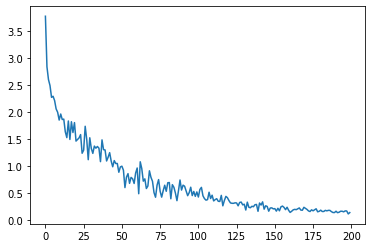

In [80]:
n_epochs = 2000
print_every = 100
plot_every = 10

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    #############
    # initialzing the cell state and input to the hidden layer, size: [1, 1, 100]
    hn, cn = model.init_hidden()
    #############
    # Load text
    inputs, targets = random_training_set()
    if inputs.size()[0] < 200: continue
    
    # Clear gradients w.r.t. parameters
    #############
    optimizer.zero_grad()
    #############
    
    # Forward pass
    loss = 0
    #############
    # repeat the forward pass for every characters in an input string
    for i in range(inputs.size()[0]):
        output, hn, cn = model(inputs[i].unsqueeze(0).unsqueeze(0).cuda(), hn, cn)
        # calculating the cross entropy loss between the predicted character and the target character
        loss += criterion(output[-1], targets[i].unsqueeze(0).cuda())
    #############
    
    # Backward pass
    #############
    loss.backward()
    #############
    
    # Updating parameters
    #############
    optimizer.step()
    #############
    
    loss_avg += loss.item() / chunk_len

    if epoch % print_every == 0:
        print('*'*25, 'epoch%d'%epoch, '*'*25)
        print('loss %.4f'%loss.item())
        print(evaluate('I', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

#################################################
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Discussion
- 논문에서 주어진 것과 같이 cell state, hidden state에 해당하는 값들과, forget gate, input gate, output gate 연산들을 활용하여 LSTM 모델을 구현하였다. 
- training과 evaluation에 해당하는 부분은 input으로 들어오는 문자열에 대해 for 문을 통해 각각의 문자들을 순차적으로 입력해 주었으며, batch size는 1로 두었다. 거기에 더해 이전 output으로 생성된 cell state, hidden state값을 input으로 받아 직전 character prediction에 대한 정보를 바탕으로 학습할 수 있었다. 
- 총 2000번의 epoch동안 Eminem의 'Lose Yourself'로부터 랜덤하게 생성된 문자열에 대해 학습을 시켰으며, epoch을 거듭할수록 각각의 gate들에 연결되어 있는 layer들은 input에 대한 최적의 cell state, hidden state가 생성되도록 학습되었다. 
- 이는 epoch가 거듭할수록 predicted string과 target string 사이의 loss 값이 감소함을 통해 정량적으로 확인할 수 있는데, 초기 100번째 epoch에서는 361.4271의 loss값을 보인 반면, 최종적으로 2000번째 epoch에서는 15.8835의 loss로 수렴하였다. 
- 실제로 예측되는 string의 값을 확인해보면, 초기 epoch에서는 같은 문자열이 여러 번 반복되는 등 실제 target string인 Eminem의 가사와는 거리가 멀었지만, 최종적으로 얻은 predicted string을 보면 target string의 일부분과 정확히 일치함을 확인할 수 있었다. 이를 통해 주어진 문자열에 대한 학습이 매우 잘 이뤄졌음을 정성적으로 확인할 수 있었다. 
- 이를 통해 길이 200의 긴 문자열을 대상으로 학습을 시키고, 길이 100짜리 예측된 긴 문자열을 출력시키는 task에서는 LSTM의 강점이 드러남을 확인할 수 있었다. 

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)

[2] [CS 231n](http://cs231n.stanford.edu/syllabus.html)(http://cs231n.stanford.edu/syllabus.html)